In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv


In [2]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import timeit

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Путь к файлу CSV
data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv"
train_data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv"
test_data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv"

# Чтение данных из CSV-файлов
data = pd.read_csv(data_path)
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [5]:
data = data.rename(columns={'atis_flight': 'intent', ' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning': 'text'})
lost_intent = {'intent': 'atis_flight', 'text': 'i want to fly from boston at 838 am and arrive in denver at 1110 in the morning'}
data = pd.concat([data, pd.DataFrame([lost_intent])], ignore_index=True)

In [6]:
# Find classes with only one sample
class_counts = data['intent'].value_counts()
single_sample_classes = class_counts[class_counts == 1].index.tolist()

# Separate single sample classes
single_sample_data = data[data['intent'].isin(single_sample_classes)]
multiple_sample_data = data[~data['intent'].isin(single_sample_classes)]

In [7]:
# train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['intent'])
# Perform stratified split on multiple sample data
train_multiple, test_multiple = train_test_split(multiple_sample_data, test_size=0.2, random_state=42, stratify=multiple_sample_data['intent'])

# Add single sample data to both train and test sets to ensure all classes are present
train = pd.concat([train_multiple, single_sample_data]).reset_index(drop=True)
test = pd.concat([test_multiple, single_sample_data]).reset_index(drop=True)

# Ensure no duplicates in train and test sets
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

unique_values_normalized = train['intent'].value_counts(normalize=True)
unique_values_normalized_test = test['intent'].value_counts(normalize=True)
print(unique_values_normalized*100, len(unique_values_normalized), len(unique_values_normalized_test))

intent
atis_flight                                 73.869079
atis_airfare                                 8.621607
atis_ground_service                          5.082491
atis_airline                                 3.113358
atis_abbreviation                            2.474721
atis_aircraft                                1.676424
atis_flight_time                             1.117616
atis_quantity                                1.091006
atis_distance                                0.425758
atis_flight#atis_airfare                     0.399148
atis_ground_fare                             0.372539
atis_airport                                 0.372539
atis_city                                    0.372539
atis_capacity                                0.345929
atis_flight_no                               0.266099
atis_meal                                    0.133049
atis_restriction                             0.106440
atis_airline#atis_flight_no                  0.053220
atis_ground_service#a

In [8]:
# Check for missing classes and ensure all classes are present
train_classes = set(train['intent'])
test_classes = set(test['intent'])
all_classes = set(data['intent'])

# Find missing classes in train and test sets
missing_train_classes = all_classes - train_classes
missing_test_classes = all_classes - test_classes

# Add missing classes examples to train and test sets
if missing_train_classes:
    missing_train_data = data[data['intent'].isin(missing_train_classes)]
    train = pd.concat([train, missing_train_data])
    train = train.drop_duplicates().reset_index(drop=True)

if missing_test_classes:
    missing_test_data = data[data['intent'].isin(missing_test_classes)]
    test = pd.concat([test, missing_test_data])
    test = test.drop_duplicates().reset_index(drop=True)

# Print unique value proportions
unique_values_normalized = train['intent'].value_counts(normalize=True)
unique_values_normalized_test = test['intent'].value_counts(normalize=True)
print(unique_values_normalized * 100, len(unique_values_normalized), len(unique_values_normalized_test)) 

intent
atis_flight                                 73.869079
atis_airfare                                 8.621607
atis_ground_service                          5.082491
atis_airline                                 3.113358
atis_abbreviation                            2.474721
atis_aircraft                                1.676424
atis_flight_time                             1.117616
atis_quantity                                1.091006
atis_distance                                0.425758
atis_flight#atis_airfare                     0.399148
atis_ground_fare                             0.372539
atis_airport                                 0.372539
atis_city                                    0.372539
atis_capacity                                0.345929
atis_flight_no                               0.266099
atis_meal                                    0.133049
atis_restriction                             0.106440
atis_airline#atis_flight_no                  0.053220
atis_ground_service#a

In [9]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [10]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # Добавление дополнительного измерения
#         print(f'x shape: {x.shape}')
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [11]:
from sklearn.preprocessing import LabelEncoder

# Создание LabelEncoder
le = LabelEncoder()

# Преобразование меток в числовые значения
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])

In [12]:
# Токенизация и преобразование в TF-IDF
tokenizer = word_tokenize
vectorizer = TfidfVectorizer(tokenizer=tokenizer)

train_texts = vectorizer.fit_transform(train['text']).toarray()
test_texts = vectorizer.transform(test['text']).toarray()

# Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
train_dataset = TextDataset(torch.from_numpy(train_texts), train_labels)
test_dataset = TextDataset(torch.from_numpy(test_texts), test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [13]:
# Создание и обучение модели
model = LSTMClassifier(input_dim=train_texts.shape[1], hidden_dim=256, output_dim=len(le.classes_))

# Перемещение модели на GPU, если он доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []


In [14]:
# n_epoches = 20

In [15]:
n_epoches = 25
for epoch in range(n_epoches):
    train_loss = 0
    val_loss = 0
    # Обучение
    model.train()
    for i, (texts, labels) in enumerate(tqdm(train_loader)):
        # Перемещение данных на тот же устройство, что и модель
        texts = texts.float().to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for i, (texts, labels) in enumerate(tqdm(test_loader)):
            texts = texts.float().to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

100%|██████████| 31/31 [00:00<00:00, 1119.47it/s]


Epoch 1, Train Loss: 1.7006526975813558, Val Loss: 0.976976151427915


100%|██████████| 31/31 [00:00<00:00, 1151.38it/s]


Epoch 2, Train Loss: 0.7822319565940712, Val Loss: 0.7136797193557985


100%|██████████| 31/31 [00:00<00:00, 1134.14it/s]


Epoch 3, Train Loss: 0.5379558441750074, Val Loss: 0.5434283316135406


100%|██████████| 31/31 [00:00<00:00, 1214.66it/s]


Epoch 4, Train Loss: 0.3841997825745809, Val Loss: 0.43282376037489984


100%|██████████| 31/31 [00:00<00:00, 1138.21it/s]


Epoch 5, Train Loss: 0.28048328887986934, Val Loss: 0.36014914200190573


100%|██████████| 31/31 [00:00<00:00, 1182.79it/s]


Epoch 6, Train Loss: 0.21271428506884535, Val Loss: 0.318906647663924


100%|██████████| 31/31 [00:00<00:00, 1194.19it/s]


Epoch 7, Train Loss: 0.1636252819039559, Val Loss: 0.2767724287846396


100%|██████████| 31/31 [00:00<00:00, 1193.71it/s]


Epoch 8, Train Loss: 0.12669896560926305, Val Loss: 0.252687722023937


100%|██████████| 31/31 [00:00<00:00, 1145.32it/s]


Epoch 9, Train Loss: 0.09794301141874265, Val Loss: 0.2330717646306561


100%|██████████| 31/31 [00:00<00:00, 1212.67it/s]


Epoch 10, Train Loss: 0.07529334618978328, Val Loss: 0.2212641282127269


100%|██████████| 31/31 [00:00<00:00, 1179.04it/s]


Epoch 11, Train Loss: 0.060055050856860005, Val Loss: 0.21348958402391402


100%|██████████| 31/31 [00:00<00:00, 1217.74it/s]


Epoch 12, Train Loss: 0.048970653608409784, Val Loss: 0.20671992435029918


100%|██████████| 31/31 [00:00<00:00, 1155.11it/s]


Epoch 13, Train Loss: 0.039598102649768534, Val Loss: 0.2086446288252069


100%|██████████| 31/31 [00:00<00:00, 1172.38it/s]


Epoch 14, Train Loss: 0.032553389335003825, Val Loss: 0.20344464509417454


100%|██████████| 31/31 [00:00<00:00, 1142.13it/s]


Epoch 15, Train Loss: 0.027334489628783095, Val Loss: 0.1995086441297204


100%|██████████| 31/31 [00:00<00:00, 1162.36it/s]


Epoch 16, Train Loss: 0.023302083963259928, Val Loss: 0.1989585347323408


100%|██████████| 31/31 [00:00<00:00, 1153.34it/s]


Epoch 17, Train Loss: 0.019561143919541422, Val Loss: 0.1938878329801223


100%|██████████| 31/31 [00:00<00:00, 1095.40it/s]


Epoch 18, Train Loss: 0.016350483996359536, Val Loss: 0.19515247196860372


100%|██████████| 31/31 [00:00<00:00, 1171.72it/s]


Epoch 19, Train Loss: 0.013906594619383815, Val Loss: 0.1967604128538721


100%|██████████| 31/31 [00:00<00:00, 1137.62it/s]


Epoch 20, Train Loss: 0.011905849323276494, Val Loss: 0.19868654016059853


100%|██████████| 31/31 [00:00<00:00, 1181.69it/s]


Epoch 21, Train Loss: 0.010566001458801882, Val Loss: 0.19946359048011683


100%|██████████| 31/31 [00:00<00:00, 1172.06it/s]


Epoch 22, Train Loss: 0.009254758517549894, Val Loss: 0.20320543908746913


100%|██████████| 31/31 [00:00<00:00, 1158.96it/s]


Epoch 23, Train Loss: 0.008258967026989212, Val Loss: 0.20428682928304037


100%|██████████| 31/31 [00:00<00:00, 1143.63it/s]


Epoch 24, Train Loss: 0.0076297311126096645, Val Loss: 0.2046459929382939


100%|██████████| 31/31 [00:00<00:00, 1162.53it/s]

Epoch 25, Train Loss: 0.006666551561635461, Val Loss: 0.20721739724526303


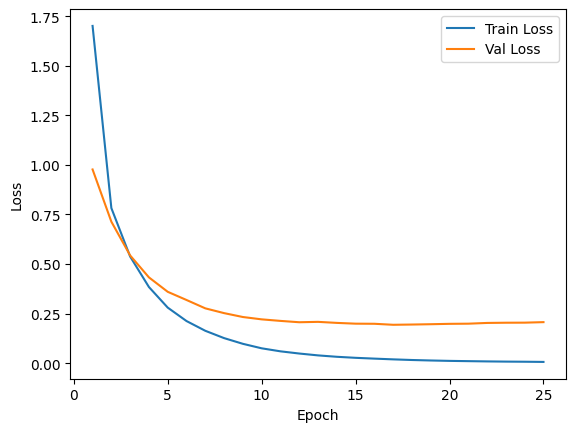

In [16]:
# Построение графика потерь
plt.plot(range(1, n_epoches + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoches + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [17]:
# import timeit
# from tqdm import tqdm

# n_epoches = 20
# train_losses = []
# val_losses = []

# for epoch in range(n_epoches):
#     train_loss = 0
#     val_loss = 0
    
#     # Обучение
#     start_train = timeit.default_timer()
#     model.train()
#     for i, (texts, labels) in enumerate(tqdm(train_loader)):
#         # Перемещение данных на тот же устройство, что и модель
#         texts = texts.float().to(device)
#         labels = labels.to(device)

#         outputs = model(texts)
#         loss = criterion(outputs, labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()
#     end_train = timeit.default_timer()
    
#     # Валидация
#     start_val = timeit.default_timer()
#     model.eval()
#     with torch.no_grad():
#         for i, (texts, labels) in enumerate(tqdm(test_loader)):
#             texts = texts.float().to(device)
#             labels = labels.to(device)

#             outputs = model(texts)
#             loss = criterion(outputs, labels)

#             val_loss += loss.item()
#     end_val = timeit.default_timer()
    
#     train_loss /= len(train_loader)
#     val_loss /= len(test_loader)
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)

#     print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')
#     print(f'Time for training: {end_train - start_train:.4f} seconds')
#     print(f'Time for validation: {end_val - start_val:.4f} seconds')

# Прогнозирование на тестовом наборе
predictions = []
start_test = timeit.default_timer()
with torch.no_grad():
    for i, (input_ids, labels) in enumerate(test_loader):
        input_ids = input_ids.float().to(device)

        outputs = model(input_ids)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
end_test = timeit.default_timer()

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')
print(balanced_accuracy_score(test_labels, predictions))
print(precision_recall_fscore_support(test_labels, predictions, average='weighted'))

Time for testing: 0.0483 seconds
Average time per response: 0.000049 seconds
0.7668988493048183
(0.9583477215099222, 0.960204081632653, 0.9586031694177314, None)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
# # Прогнозирование на тестовом наборе
# predictions = []
# with torch.no_grad():
#     for i, (input_ids, labels) in enumerate(test_loader):
#         input_ids = input_ids.float().to(device)

#         outputs = model(input_ids)
#         _, predicted = torch.max(outputs.data, 1)
#         predictions.extend(predicted.cpu().numpy())

# # Перевод меток обратно в исходные интенты
# predicted_intents = le.inverse_transform(predictions)

# print(balanced_accuracy_score(test_labels, predictions))
# print(precision_recall_fscore_support(test_labels, predictions, average = 'weighted'))

In [19]:
# # Построение confusion matrix
# labels = data['intent'].unique()  # получите уникальные метки классов
# cm = confusion_matrix(test['intent'], predicted_intents, labels=labels)
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.title(f'Logistic Regression')
# plt.show()

In [20]:
def plotCM(test, predictions, name:'str'):
    # Построение confusion matrix
    labels = test['intent'].unique()  # получите уникальные метки классов
    cm = confusion_matrix(test['intent'], predictions, labels=labels)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f'{name}')
    plt.show()

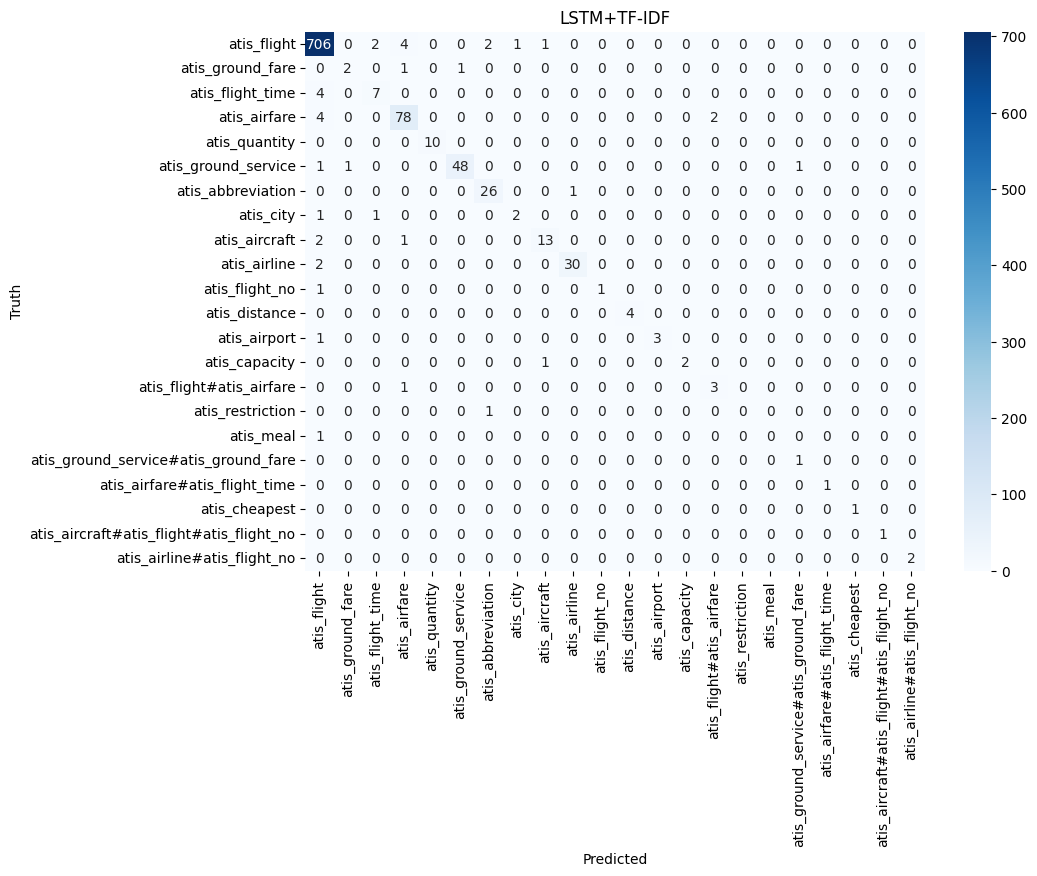

In [21]:
plotCM(test, predicted_intents,'LSTM+TF-IDF')

Mini-LM
sentence-transformers/all-MiniLM-L6-v2

In [22]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [23]:
# Создание пользовательского Dataset класса
class TextDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]
    
# Определение модели LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hn, _) = self.lstm(x.unsqueeze(1))
        out = self.fc(hn[-1])
        return out

In [24]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [25]:
# Tokenize and encode the text data
train_encodings = tokenizer(train['text'].tolist(), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(test['text'].tolist(), truncation=True, padding=True, return_tensors="pt")

# Extract embeddings
with torch.no_grad():
    train_embeddings = model(**train_encodings).pooler_output
    test_embeddings = model(**test_encodings).pooler_output

le = LabelEncoder()

# Преобразование меток в числовые значения
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])


# Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
train_dataset = TextDataset(train_embeddings, torch.tensor(train_labels))
test_dataset = TextDataset(test_embeddings, torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [26]:
# Создание и обучение модели
model = LSTMClassifier(input_dim=train_embeddings.shape[1], hidden_dim=256, output_dim=len(le.classes_))

# Перемещение модели на GPU, если он доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

n_epoches = 25


100%|██████████| 31/31 [00:00<00:00, 1351.92it/s]


Epoch 1, Train Loss: 1.3637439628778878, Val Loss: 1.0380957895709622


100%|██████████| 31/31 [00:00<00:00, 1291.97it/s]


Epoch 2, Train Loss: 0.8234455206636655, Val Loss: 0.6971750951582386


100%|██████████| 31/31 [00:00<00:00, 1291.40it/s]


Epoch 3, Train Loss: 0.5442175298171529, Val Loss: 0.5387543617717682


100%|██████████| 31/31 [00:00<00:00, 1290.13it/s]


Epoch 4, Train Loss: 0.4286399425591453, Val Loss: 0.47063158308306047


100%|██████████| 31/31 [00:00<00:00, 1322.71it/s]


Epoch 5, Train Loss: 0.36697702678078314, Val Loss: 0.4221026606617435


100%|██████████| 31/31 [00:00<00:00, 1277.23it/s]


Epoch 6, Train Loss: 0.322771859371056, Val Loss: 0.38988160173739156


100%|██████████| 31/31 [00:00<00:00, 1291.99it/s]


Epoch 7, Train Loss: 0.2901103993783058, Val Loss: 0.36848681444121945


100%|██████████| 31/31 [00:00<00:00, 1312.90it/s]


Epoch 8, Train Loss: 0.27000394877109485, Val Loss: 0.3430707053311409


100%|██████████| 31/31 [00:00<00:00, 1317.47it/s]


Epoch 9, Train Loss: 0.24819066208171642, Val Loss: 0.3366448446627586


100%|██████████| 31/31 [00:00<00:00, 993.42it/s]


Epoch 10, Train Loss: 0.23278952593583677, Val Loss: 0.31397100706254283


100%|██████████| 31/31 [00:00<00:00, 1337.62it/s]


Epoch 11, Train Loss: 0.21613212723790085, Val Loss: 0.30801285538942585


100%|██████████| 31/31 [00:00<00:00, 1342.15it/s]


Epoch 12, Train Loss: 0.20082574440324205, Val Loss: 0.29500324615547735


100%|██████████| 31/31 [00:00<00:00, 1333.25it/s]


Epoch 13, Train Loss: 0.1886229468667406, Val Loss: 0.28149404701205993


100%|██████████| 31/31 [00:00<00:00, 1312.84it/s]


Epoch 14, Train Loss: 0.1773658283370531, Val Loss: 0.2824327885623901


100%|██████████| 31/31 [00:00<00:00, 1316.89it/s]


Epoch 15, Train Loss: 0.1659922542176762, Val Loss: 0.2679328502666566


100%|██████████| 31/31 [00:00<00:00, 1358.80it/s]


Epoch 16, Train Loss: 0.15272970118765103, Val Loss: 0.28896294870684225


100%|██████████| 31/31 [00:00<00:00, 1265.32it/s]


Epoch 17, Train Loss: 0.15142810554638253, Val Loss: 0.2679712760352319


100%|██████████| 31/31 [00:00<00:00, 1286.62it/s]


Epoch 18, Train Loss: 0.1412570705416344, Val Loss: 0.2526826411485672


100%|██████████| 31/31 [00:00<00:00, 1289.15it/s]


Epoch 19, Train Loss: 0.1327076647114956, Val Loss: 0.24333151489976915


100%|██████████| 31/31 [00:00<00:00, 1308.04it/s]


Epoch 20, Train Loss: 0.12342032637068276, Val Loss: 0.24572390233797411


100%|██████████| 31/31 [00:00<00:00, 1323.78it/s]


Epoch 21, Train Loss: 0.11739145229586352, Val Loss: 0.24271110697619377


100%|██████████| 31/31 [00:00<00:00, 1318.29it/s]


Epoch 22, Train Loss: 0.10938853717614282, Val Loss: 0.24690712760052375


100%|██████████| 31/31 [00:00<00:00, 1314.35it/s]


Epoch 23, Train Loss: 0.10739515069082885, Val Loss: 0.23190151845976228


100%|██████████| 31/31 [00:00<00:00, 1302.40it/s]


Epoch 24, Train Loss: 0.09905238241999079, Val Loss: 0.2315938719097645


100%|██████████| 31/31 [00:00<00:00, 1367.49it/s]


Epoch 25, Train Loss: 0.09462382986162932, Val Loss: 0.23321860355715598


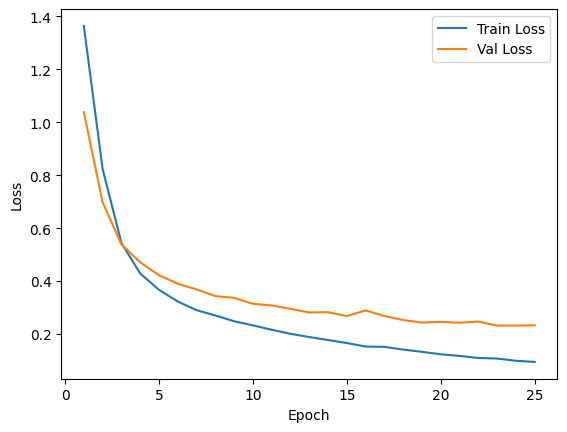

In [27]:
for epoch in range(n_epoches):
    train_loss = 0
    val_loss = 0
    # Обучение
    model.train()
    for texts, labels in tqdm(train_loader):
        # Перемещение данных на тот же устройство, что и модель
        texts = texts.float().to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for texts, labels in tqdm(test_loader):
            texts = texts.float().to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

# Построение графика потерь
plt.plot(range(1, n_epoches + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoches + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# # Прогнозирование на тестовом наборе
# predictions = []
# with torch.no_grad():
#     for i, (input_ids, labels) in enumerate(test_loader):
#         input_ids = input_ids.float().to(device)

#         outputs = model(input_ids)
#         _, predicted = torch.max(outputs.data, 1)
#         predictions.extend(predicted.cpu().numpy())

# # Перевод меток обратно в исходные интенты
# predicted_intents = le.inverse_transform(predictions)

# print("precision_recall_fscore weighted", precision_recall_fscore_support(test['intent'], predicted_intents, average='weighted'))
# print("balanced_accuracy", balanced_accuracy_score(test['intent'], predicted_intents))

In [29]:
# Прогнозирование на тестовом наборе
predictions = []
start_test = timeit.default_timer()
with torch.no_grad():
    for i, (input_ids, labels) in enumerate(test_loader):
        input_ids = input_ids.float().to(device)

        outputs = model(input_ids)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
end_test = timeit.default_timer()

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')
print("precision_recall_fscore weighted", precision_recall_fscore_support(test['intent'], predicted_intents, average='weighted'))
print("balanced_accuracy", balanced_accuracy_score(test['intent'], predicted_intents))

Time for testing: 0.0239 seconds
Average time per response: 0.000024 seconds
precision_recall_fscore weighted (0.9159505933302464, 0.9326530612244898, 0.9210494194709854, None)
balanced_accuracy 0.4329806007848758


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


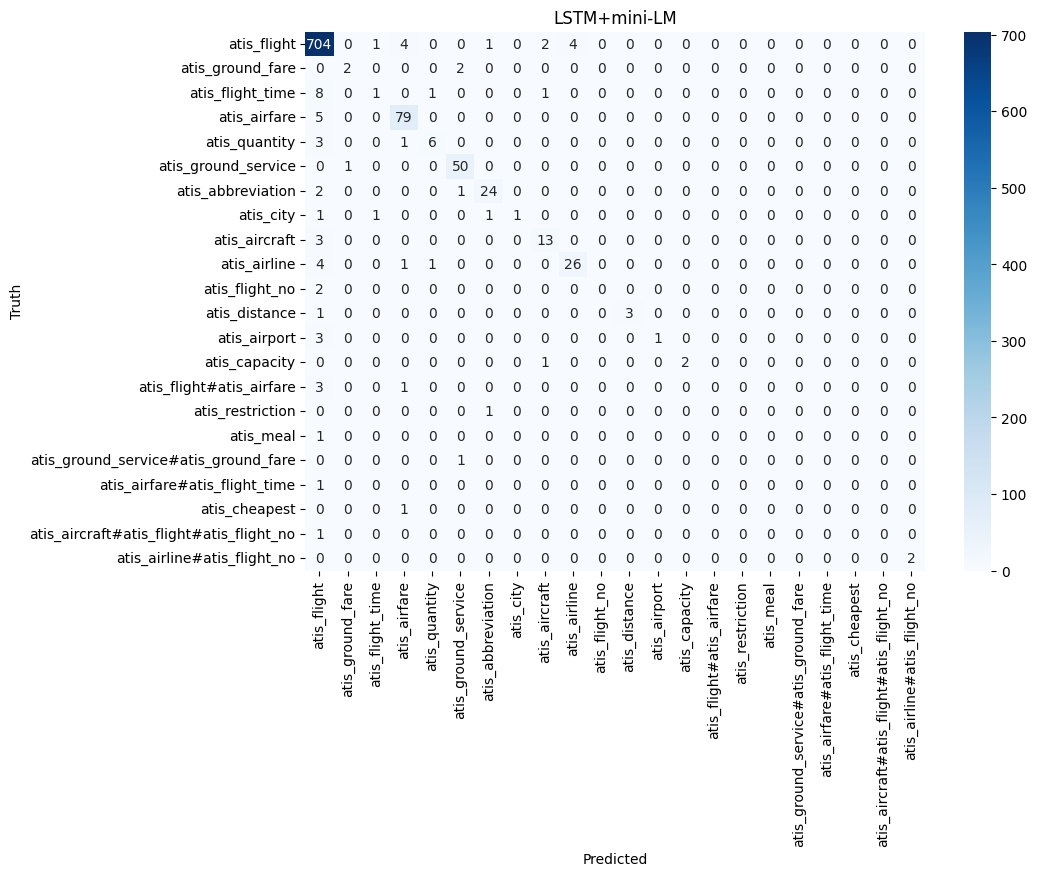

In [30]:
plotCM(test, predicted_intents, 'LSTM+mini-LM')

M-USE

In [31]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sadakmed/distiluse-base-multilingual-cased-v2")
model = AutoModel.from_pretrained("sadakmed/distiluse-base-multilingual-cased-v2")

tokenizer_config.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/539M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [32]:
# Tokenize and encode the text data
train_encodings = tokenizer(train['text'].tolist(), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(test['text'].tolist(), truncation=True, padding=True, return_tensors="pt")

# Извлечение эмбеддингов
with torch.no_grad():
    train_embeddings = model(**train_encodings).last_hidden_state.mean(dim=1)
    test_embeddings = model(**test_encodings).last_hidden_state.mean(dim=1)

le = LabelEncoder()

# Преобразование меток в числовые значения
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])


# Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
train_dataset = TextDataset(train_embeddings, torch.tensor(train_labels))
test_dataset = TextDataset(test_embeddings, torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [33]:
# Создание и обучение модели
model = LSTMClassifier(input_dim=train_embeddings.shape[1], hidden_dim=256, output_dim=len(le.classes_))

# Перемещение модели на GPU, если он доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

n_epoches = 25

100%|██████████| 31/31 [00:00<00:00, 1275.00it/s]


Epoch 1, Train Loss: 1.1564891732345193, Val Loss: 0.7899214077380395


100%|██████████| 31/31 [00:00<00:00, 1285.02it/s]


Epoch 2, Train Loss: 0.5697049866667239, Val Loss: 0.5200850982819835


100%|██████████| 31/31 [00:00<00:00, 1243.01it/s]


Epoch 3, Train Loss: 0.39478604672318796, Val Loss: 0.4053144647229102


100%|██████████| 31/31 [00:00<00:00, 1257.32it/s]


Epoch 4, Train Loss: 0.2937724406562619, Val Loss: 0.33653388412729385


100%|██████████| 31/31 [00:00<00:00, 1269.70it/s]


Epoch 5, Train Loss: 0.2329648496204261, Val Loss: 0.27658055578508683


100%|██████████| 31/31 [00:00<00:00, 1297.64it/s]


Epoch 6, Train Loss: 0.1819620794158871, Val Loss: 0.2554884516904431


100%|██████████| 31/31 [00:00<00:00, 1271.88it/s]


Epoch 7, Train Loss: 0.14741921544832698, Val Loss: 0.2258586657624091


100%|██████████| 31/31 [00:00<00:00, 1259.37it/s]


Epoch 8, Train Loss: 0.12454887608981739, Val Loss: 0.20419613271951675


100%|██████████| 31/31 [00:00<00:00, 1252.40it/s]


Epoch 9, Train Loss: 0.11022700772668093, Val Loss: 0.1862872182842224


100%|██████████| 31/31 [00:00<00:00, 1232.57it/s]


Epoch 10, Train Loss: 0.09154363438266061, Val Loss: 0.2163747424079526


100%|██████████| 31/31 [00:00<00:00, 1263.68it/s]


Epoch 11, Train Loss: 0.08314613297865805, Val Loss: 0.1961493764913851


100%|██████████| 31/31 [00:00<00:00, 1306.19it/s]


Epoch 12, Train Loss: 0.06899589744901632, Val Loss: 0.1721961296373798


100%|██████████| 31/31 [00:00<00:00, 1280.98it/s]


Epoch 13, Train Loss: 0.06013733311950908, Val Loss: 0.17340148937317632


100%|██████████| 31/31 [00:00<00:00, 1227.98it/s]


Epoch 14, Train Loss: 0.05440918864855953, Val Loss: 0.16244895726201997


100%|██████████| 31/31 [00:00<00:00, 1239.05it/s]


Epoch 15, Train Loss: 0.050387926944294725, Val Loss: 0.15198842225776565


100%|██████████| 31/31 [00:00<00:00, 1201.72it/s]


Epoch 16, Train Loss: 0.04490977866867147, Val Loss: 0.15417409051329858


100%|██████████| 31/31 [00:00<00:00, 1095.59it/s]


Epoch 17, Train Loss: 0.04049471392241007, Val Loss: 0.17232875183465018


100%|██████████| 31/31 [00:00<00:00, 1249.91it/s]


Epoch 18, Train Loss: 0.03626278111063954, Val Loss: 0.16953544276616267


100%|██████████| 31/31 [00:00<00:00, 1249.64it/s]


Epoch 19, Train Loss: 0.03240025189697301, Val Loss: 0.18211675173933467


100%|██████████| 31/31 [00:00<00:00, 1202.85it/s]


Epoch 20, Train Loss: 0.028021733429464433, Val Loss: 0.14198422858551626


100%|██████████| 31/31 [00:00<00:00, 1236.82it/s]


Epoch 21, Train Loss: 0.024183949151755136, Val Loss: 0.1647855351949411


100%|██████████| 31/31 [00:00<00:00, 1230.94it/s]


Epoch 22, Train Loss: 0.024796674590384177, Val Loss: 0.18356799457462564


100%|██████████| 31/31 [00:00<00:00, 1238.33it/s]


Epoch 23, Train Loss: 0.020768911324705833, Val Loss: 0.20544991630219644


100%|██████████| 31/31 [00:00<00:00, 994.51it/s]


Epoch 24, Train Loss: 0.019985067209236766, Val Loss: 0.15894998543925823


100%|██████████| 31/31 [00:00<00:00, 1270.85it/s]


Epoch 25, Train Loss: 0.017404648085653594, Val Loss: 0.17052125146672611


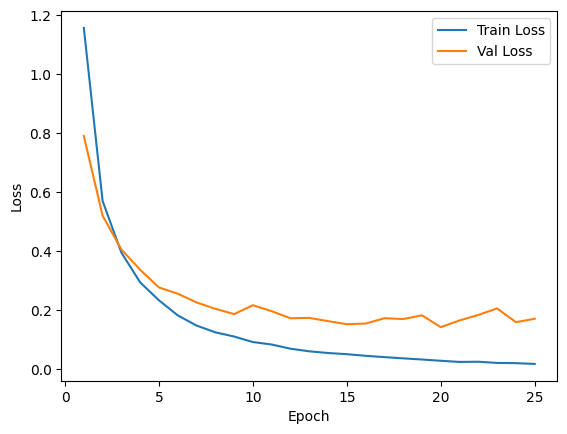

In [34]:
for epoch in range(n_epoches):
    train_loss = 0
    val_loss = 0
    # Обучение
    model.train()
    for texts, labels in tqdm(train_loader):
        # Перемещение данных на тот же устройство, что и модель
        texts = texts.float().to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for texts, labels in tqdm(test_loader):
            texts = texts.float().to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

# Построение графика потерь
plt.plot(range(1, n_epoches + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoches + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
# # Прогнозирование на тестовом наборе
# predictions = []
# with torch.no_grad():
#     for i, (input_ids, labels) in enumerate(test_loader):
#         input_ids = input_ids.float().to(device)

#         outputs = model(input_ids)
#         _, predicted = torch.max(outputs.data, 1)
#         predictions.extend(predicted.cpu().numpy())

# # Перевод меток обратно в исходные интенты
# predicted_intents = le.inverse_transform(predictions)

# print("precision_recall_fscore weighted", precision_recall_fscore_support(test['intent'], predicted_intents, average='weighted'))
# print("balanced_accuracy", balanced_accuracy_score(test['intent'], predicted_intents))

In [36]:
# Прогнозирование на тестовом наборе
predictions = []
start_test = timeit.default_timer()
with torch.no_grad():
    for i, (input_ids, labels) in enumerate(test_loader):
        input_ids = input_ids.float().to(device)

        outputs = model(input_ids)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
end_test = timeit.default_timer()

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')
print("precision_recall_fscore weighted", precision_recall_fscore_support(test['intent'], predicted_intents, average='weighted'))
print("balanced_accuracy", balanced_accuracy_score(test['intent'], predicted_intents))

Time for testing: 0.0268 seconds
Average time per response: 0.000027 seconds
precision_recall_fscore weighted (0.9649371308216369, 0.9591836734693877, 0.9605448440260411, None)
balanced_accuracy 0.8855066548758106


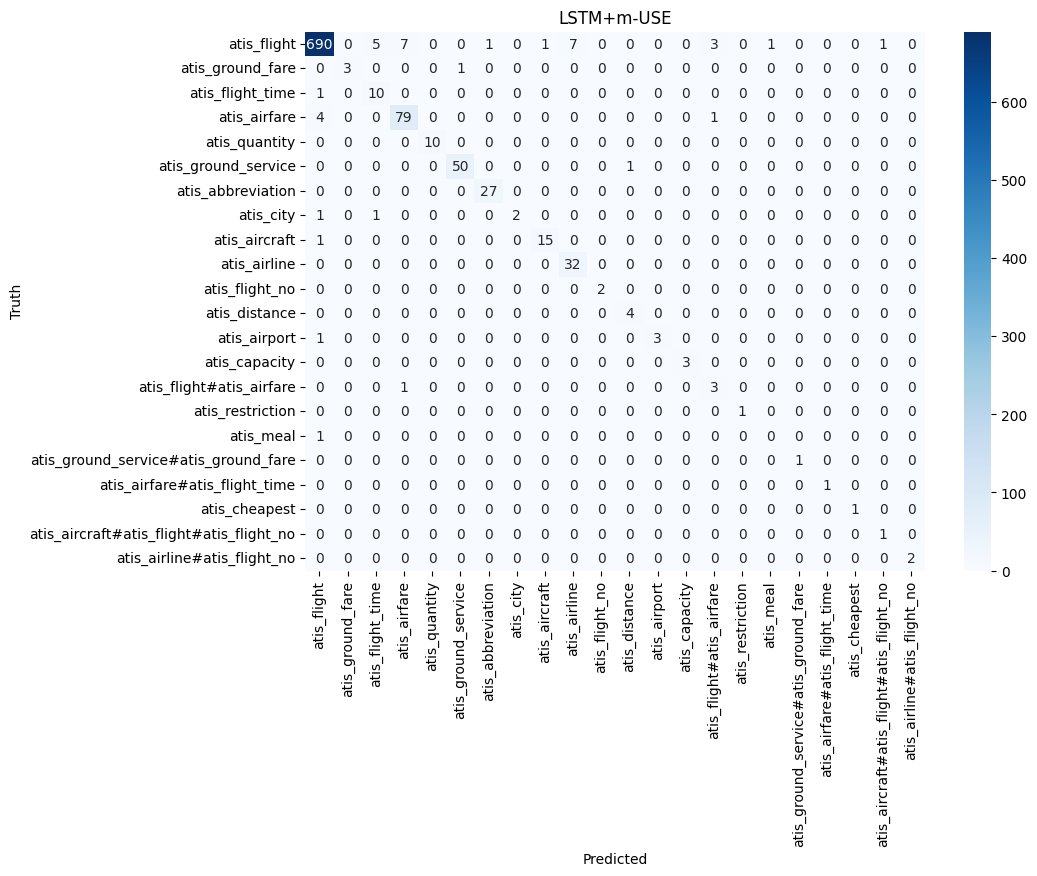

In [37]:
plotCM(test, predicted_intents, 'LSTM+m-USE')